In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2

The purpose of this video is to understand the errors on the fit parameters whenever one fits data to a curve. In particular

* One fits a curve $y=f(x,\beta)$ to data $x_{\text{data}}$ and $y_{\text{data}}$ with errors $\sigma_{\text{data}}$ and obtains the optimal parameters $\beta$ such that the $\chi^2$ value is minimized:

$$\chi^2 = \sum_i (f(x_i, \beta) - y_i)^2/\sigma_i^2$$

For example:

In [5]:
0.1*np.random.randn(2) + 5

array([5.35296425, 2.57182787])

In [6]:
x_data = np.linspace(0, 2*np.pi, 20)
yerr_data = 0.1*np.random.randn(len(x_data))
y_data = 3*np.exp(-2*x_data) + yerr_data

We plot the data

<ErrorbarContainer object of 3 artists>

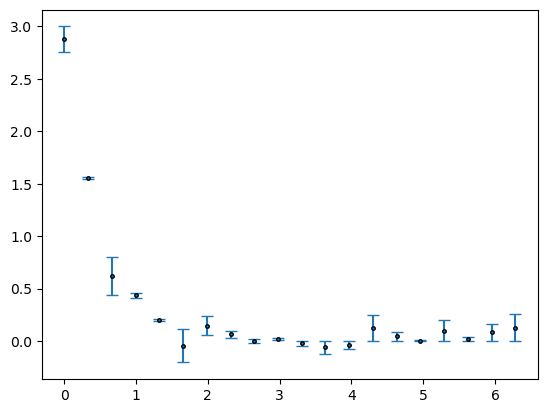

In [7]:
plt.errorbar(x_data, y_data, yerr_data, ls='', capsize=4, marker='.', ms=5, mec='black')

We fit it to the exponential decay function $y=ae^{-bx}$ so the parameters are $\beta=(a,b)$

In [8]:
def fit_func(x, a, b):
    return a*np.exp(-b*x)
popt, pcov = curve_fit(fit_func, x_data, y_data, sigma=yerr_data)
perr = np.sqrt(np.diag(pcov))

In [12]:
np.sqrt(np.diag(pcov))

array([0.04726301, 0.04512273])

Then we can plot next to the data:

In [14]:
x_model = np.linspace(min(x_data), max(x_data), 100)
y_model = fit_func(x_model, *popt)

<ErrorbarContainer object of 3 artists>

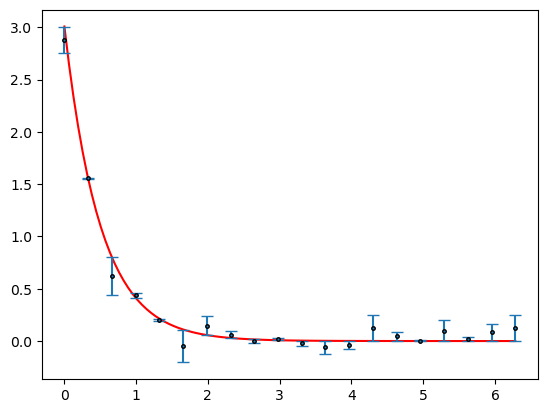

In [15]:
plt.plot(x_model, y_model, color='r')
plt.errorbar(x_data, y_data, yerr_data, ls='', capsize=4, marker='.', ms=5, mec='black')

In [16]:
popt

array([3.0080469 , 1.99753418])

In [17]:
perr

array([0.04726301, 0.04512273])

# What Do The Errors Actually Mean?

The errors are defined in a very specific way. To understand this, we first need to understand the $\chi^2$ distribution. It's essentially just a probability density function, but with a "degrees of freedom" parameter.

$$f(\chi^2; n) = \frac{1}{2^{n/2}\Gamma(n/2)} e^{-\chi^2 / 2}(\chi^2)^{(n/2)-1}

In [28]:
x = np.linspace(0,40,100)
y = chi2.pdf(x, df=18)

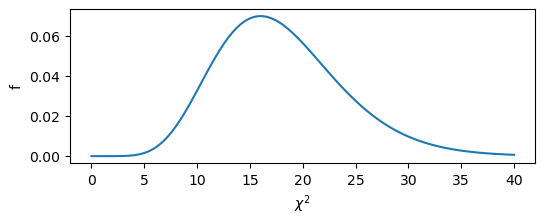

In [29]:
plt.figure(figsize=(6,2))
plt.plot(x,y)
plt.xlabel(r'$\chi^2$')
plt.ylabel('f')
plt.show()

What does the degrees of freedom parameter mean? And what does that probability density function actually model?

* **The $\chi^2$ distribution gives the probability density function of $\sum_i N_i(1,0)^2$ where $N_i(\mu, \sigma)$ is a Gaussian random variable. Furthermore, all the $N_i$ must be independent from one another.**

You can generate $\chi^2$ random variables as follows:

In [43]:
np.sum(np.random.randn(18)**2)

19.922203781751225

And these will be distributed according to the $\chi^2$ distribution with the appropriate degrees of freedom

In [52]:
dof = 18
chi2_values = (np.random.randn(dof*10000)**2).reshape(10000,dof).sum(axis=1)

In [53]:
chi2_values.shape

(10000,)

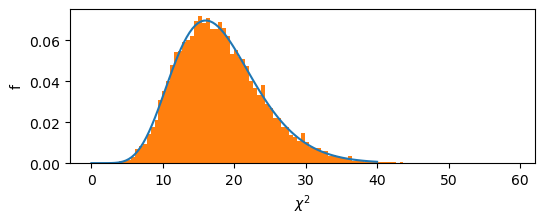

In [55]:
plt.figure(figsize=(6,2))
plt.plot(x,y)
plt.hist(chi2_values, bins=100, density=True)
plt.xlabel(r'$\chi^2$')
plt.ylabel('f')
plt.show()

# So How Is This Related To The Curve Fit Parameters?

Note the similarity between

* $$\sum_{i=1}^{M_1} N_i(1,0)^2$$
* $$\sum_{i=1}^{M_2} (f(x_i, \beta_{\text{opt}}) - y_i)^2/\sigma_i^2$$

It turns out if $y_i$ is a Gaussian random variable with $\mu = f(x_i, \beta_{\text{true}})$ and $\sigma=\sigma_i$, then the second sum is equal to the first sum if $M_1 = M_2 - ||\beta||_0$ where $|| \cdot ||_0$ counts the number of elements in a vector.

* This is because $\beta_{\text{opt}}$ is itself dependent on all the $x_i$ and $y_i$, so the terms in the sum aren't actually *indepedent* $N(0,1)$ random variables

* If $\beta_{\text{opt}}$ (the $\beta$ obtained by using `curve_fit`) was replaced with $\beta_{\text{true}}$ (the true value of $\beta$, unknown), then the two sums would be equal when $M_1=M_2$

In [57]:
def get_chi2_fitvalue(xdata, ydata, yerrdata, model_f, popt):
    return sum((model_f(xdata, *popt)-ydata)**2 / yerrdata**2)

We can compute $\chi^2$ for our old fit:

In [58]:
get_chi2_fitvalue(x_data, y_data, yerr_data, fit_func, popt)

19.232894328510966

This function will compute many data sets and compute many $\chi^2$ values

In [80]:
def create_data_and_get_chi2():
    x_data = np.linspace(0, 2*np.pi, 20)
    yerr_data = 0.1*np.random.randn(len(x_data))
    y_data = 3*np.exp(-2*x_data) + yerr_data
    popt, pcov = curve_fit(fit_func, x_data, y_data, sigma=0.1*np.ones(len(x_data)))
    return get_chi2_fitvalue(x_data, y_data, 0.1*np.ones(len(x_data)), fit_func, popt)

Let's compute a bunch of different $\chi^2$ values for a bunch of different data sets and compare them to the true $\chi^2$ distribution

In [81]:
chi2s = np.array([create_data_and_get_chi2() for i in range(10000)])

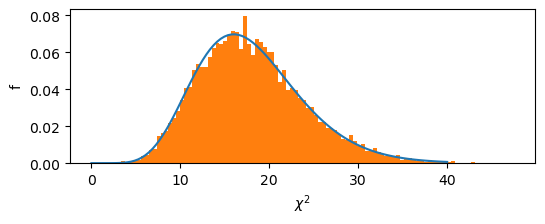

In [82]:
plt.figure(figsize=(6,2))
plt.plot(x,y)
plt.hist(chi2s, bins=100, density=True)
plt.xlabel(r'$\chi^2$')
plt.ylabel('f')
plt.show()

# Error On The Parameters

So we've shown that $$\sum_{i=1}^{M} (f(x_i, \beta_{\text{opt}}) - y_i)^2/\sigma_i^2$$ is distributed according to a $\chi^2$ distribution with $M - ||\beta||_0$ degrees of freedom. (If we collect many many data sets, and histogram the $\chi^2$ values, it will follow the appropriate distribution). Note this is true only for the optimal value of $\beta$ inserted in the sum; any other value of $\beta$ will not have that sum be distributed according to a $\chi^2$ distribution. This is why "chi2-minimization" is a bit of a misnomer.:

**We only get a true $\chi^2$ value when the sum is actually minimized.**

The error on the parameters are then defined as follows: if $\delta_a$ is an error on $a_{\text{opt}}$, then $\delta_a$ is defined such that inserting $a_{opt} \pm \delta_a$ into $\beta$, and reoptimizing all the other parameters to get $\beta_{\text{opt}}'$ makes the sum $\sum_{i=1}^{M} (f(x_i, \beta_{\text{opt}}') - y_i)^2/\sigma_i^2$ increase exactly by 1. Confused? Let's do this via code:

In [83]:
fit_func_1parameter = lambda x, b: fit_func(x, popt[0]+perr[0], b)

So we've create a new function $f(x) = (a_{\text{opt}} + \delta_a)e^{-bx}$ where the only parameter we're fitting for is $b$. Now we can optimize the fit by adjusting $b$, and compute the new $\chi^2$ value

In [84]:
popt_1parameter, pcov_1parameter = curve_fit(fit_func_1parameter, x_data, y_data, sigma=yerr_data)
get_chi2_fitvalue(x_data, y_data, yerr_data, fit_func_1parameter, popt_1parameter)

20.27699187861013

Compared to our old $\chi^2$ value:

In [87]:
get_chi2_fitvalue(x_data, y_data, yerr_data, fit_func, popt)

19.232894328510966

So we see that it's approximately 1 greater. In conclusion:

* The error $\delta_a$ of an optimal parameter $a_{\text{opt}}$ if defined such that fixing the parameter $a=a_{\text{opt}} \pm \delta_a$ and reoptimizing for all other parameters makes the sum $\sum_{i=1}^{M} (f(x_i, \beta_{\text{opt}}) - y_i)^2/\sigma_i^2$ increase exactly by 1.